In [1]:
import warnings, os, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve,
                             classification_report, confusion_matrix)

np.random.seed(42); tf.random.set_seed(42)
print("TF:", tf.__version__)


TF: 2.11.1


In [2]:
# SENDEKI DOSYA YOLU — gerekirse değiştir:
CSV_PATH = "Credit_Card_Applications.csv"  # /mnt/data/... da olabilir

df = pd.read_csv(CSV_PATH)
assert "Class" in df.columns, "Class etiketi yok!"

# 1) ID'yi at
for col in ["CustomerID", "customerID", "CustomerId", "ID", "Id"]:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"Dropped ID column: {col}")

print("Şekil:", df.shape)
df.head(3)


Dropped ID column: CustomerID
Şekil: (690, 15)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0


In [3]:
y = df["Class"].astype(int).values
X = df.drop(columns=["Class"])

# Kategorik/sayısal otomatik ayrımı:
# - ≤10 benzersiz değeri olan sütunları "kategorik" sayıyoruz (label kodlar dahil)
# - diğerleri sayısal
cat_cols, num_cols = [], []
for c in X.columns:
    nunique = X[c].nunique(dropna=True)
    if nunique <= 10:
        cat_cols.append(c)
    else:
        num_cols.append(c)

print("Sayısal:", num_cols)
print("Kategorik:", cat_cols)

# 70/15/15 split (stratify ile sınıf dengesini koru)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)
print("Split shapes:", X_train.shape, X_valid.shape, X_test.shape)


Sayısal: ['A2', 'A3', 'A5', 'A7', 'A10', 'A13', 'A14']
Kategorik: ['A1', 'A4', 'A6', 'A8', 'A9', 'A11', 'A12']
Split shapes: (483, 14) (103, 14) (104, 14)


In [4]:
# OneHotEncoder (sparse=False için API versiyon farkına dikkat)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", ohe,            cat_cols),
    ],
    remainder="drop"
)

# Fit sadece train'de; valid/test'te transform
X_train_p = preprocess.fit_transform(X_train)
X_valid_p = preprocess.transform(X_valid)
X_test_p  = preprocess.transform(X_test)

print("Feature dim after OHE+scale:", X_train_p.shape[1])

# AE'yi yalniz normal (Class=0) ile eğitelim
X_train_norm = X_train_p[y_train == 0]
print("Train normals:", X_train_norm.shape[0], "/", X_train_p.shape[0])


Feature dim after OHE+scale: 29
Train normals: 268 / 483


In [5]:
input_dim = X_train_p.shape[1]

def build_ae(d=input_dim, latent=32, hidden=128, dropout=0.2):
    inp = layers.Input(shape=(d,))
    x = layers.Dense(hidden, activation="relu")(inp)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden//2, activation="relu")(x)
    z = layers.Dense(latent, activation="relu", name="bottleneck")(x)
    x = layers.Dense(hidden//2, activation="relu")(z)
    x = layers.Dropout(dropout/2)(x)
    out = layers.Dense(d, activation=None)(x)       # regresyon çıktısı
    return models.Model(inp, out, name="tabular_ae_mae")

ae = build_ae()
ae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mae")
ae.summary()


Model: "tabular_ae_mae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 128)               3840      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 bottleneck (Dense)          (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)             

Epoch 1/200
1/2 [==============>...............] - ETA: 1s - loss: 0.4331
Epoch 1: val_loss improved from inf to 0.50045, saving model to ae_fraud_best.keras
2/2 [==============================] - 1s 281ms/step - loss: 0.4322 - val_loss: 0.5005 - lr: 0.0010
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 0.4020
Epoch 2: val_loss improved from 0.50045 to 0.48141, saving model to ae_fraud_best.keras
2/2 [==============================] - 0s 85ms/step - loss: 0.4012 - val_loss: 0.4814 - lr: 0.0010
Epoch 3/200
1/2 [==============>...............] - ETA: 0s - loss: 0.3871
Epoch 3: val_loss improved from 0.48141 to 0.47019, saving model to ae_fraud_best.keras
2/2 [==============================] - 0s 85ms/step - loss: 0.3866 - val_loss: 0.4702 - lr: 0.0010
Epoch 4/200
1/2 [==============>...............] - ETA: 0s - loss: 0.3776
Epoch 4: val_loss improved from 0.47019 to 0.46281, saving model to ae_fraud_best.keras
2/2 [==============================] - 0s 85ms/step - loss

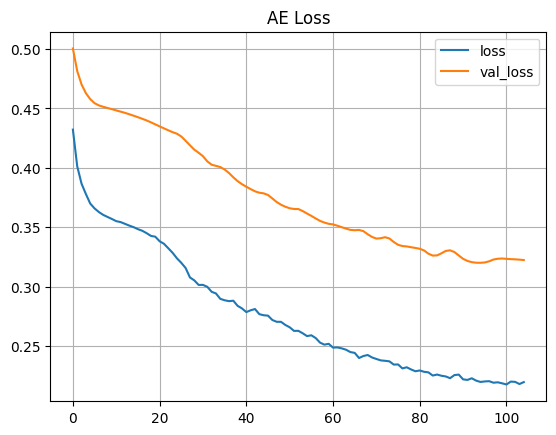

In [6]:
ckpt   = callbacks.ModelCheckpoint("ae_fraud_best.keras", save_best_only=True,
                                   monitor="val_loss", verbose=1)
early  = callbacks.EarlyStopping(monitor="val_loss", patience=10,
                                 restore_best_weights=True, verbose=1)
plateau= callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                     patience=4, min_lr=1e-5, verbose=1)

history = ae.fit(
    X_train_norm, X_train_norm,
    validation_data=(X_valid_p, X_valid_p),
    epochs=200, batch_size=256, verbose=1,
    callbacks=[ckpt, early, plateau]
)

pd.DataFrame(history.history)[["loss","val_loss"]].plot(title="AE Loss", grid=True); plt.show()


In [7]:
valid_rec = ae.predict(X_valid_p, verbose=0)
test_rec  = ae.predict(X_test_p,  verbose=0)

# MAE kullandığımız için rekonstrüksiyon MAE'yi skor yapalım
err_valid = np.mean(np.abs(X_valid_p - valid_rec), axis=1)
err_test  = np.mean(np.abs(X_test_p  - test_rec ), axis=1)

print("VAL  ROC-AUC:", roc_auc_score(y_valid, err_valid),
      "| PR-AUC:", average_precision_score(y_valid, err_valid))
print("TEST ROC-AUC:", roc_auc_score(y_test,  err_test ),
      "| PR-AUC:", average_precision_score(y_test,  err_test ))


VAL  ROC-AUC: 0.8138825324180017 | PR-AUC: 0.7884523741898465
TEST ROC-AUC: 0.8062218890554722 | PR-AUC: 0.80383008297898


In [8]:
from sklearn.metrics import auc

def pick_threshold_by_f1(y_true, scores):
    p,r,t = precision_recall_curve(y_true, scores)
    f1 = 2*p[:-1]*r[:-1]/(p[:-1]+r[:-1]+1e-12)
    i  = np.argmax(f1)
    return t[i], p[i], r[i], f1[i]

def pick_threshold_by_precision(y_true, scores, target_p=0.90):
    p,r,t = precision_recall_curve(y_true, scores)
    idx = np.where(p[:-1] >= target_p)[0]
    if len(idx)==0:
        return pick_threshold_by_f1(y_true, scores)
    i = idx[np.argmax(r[idx])]
    f1 = 2*p[i]*r[i]/(p[i]+r[i]+1e-12)
    return t[i], p[i], r[i], f1

thr_f1, pf1, rf1, f1f1 = pick_threshold_by_f1(y_valid, err_valid)
thr_p9, pp, rp, fp = pick_threshold_by_precision(y_valid, err_valid, 0.90)

print(f"[VALID F1-opt] thr={thr_f1:.6f} | P={pf1:.3f} R={rf1:.3f} F1={f1f1:.3f}")
print(f"[VALID P>=0.90] thr={thr_p9:.6f} | P={pp:.3f} R={rp:.3f} F1={fp:.3f}")


[VALID F1-opt] thr=0.241075 | P=0.639 R=0.848 F1=0.729
[VALID P>=0.90] thr=0.638286 | P=0.900 R=0.196 F1=0.321


In [9]:
def report_at_threshold(y_true, scores, thr, title=""):
    y_hat = (scores >= thr).astype(int)
    print(title)
    print(classification_report(y_true, y_hat, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_hat))

print("\n=== TEST @ F1-opt threshold ===")
report_at_threshold(y_test, err_test, thr_f1, title=f"thr={thr_f1:.6f}")

print("\n=== TEST @ Precision>=0.90 threshold ===")
report_at_threshold(y_test, err_test, thr_p9, title=f"thr={thr_p9:.6f}")



=== TEST @ F1-opt threshold ===
thr=0.241075
              precision    recall  f1-score   support

           0     0.8163    0.6897    0.7477        58
           1     0.6727    0.8043    0.7327        46

    accuracy                         0.7404       104
   macro avg     0.7445    0.7470    0.7402       104
weighted avg     0.7528    0.7404    0.7410       104

Confusion matrix:
 [[40 18]
 [ 9 37]]

=== TEST @ Precision>=0.90 threshold ===
thr=0.638286
              precision    recall  f1-score   support

           0     0.6170    1.0000    0.7632        58
           1     1.0000    0.2174    0.3571        46

    accuracy                         0.6538       104
   macro avg     0.8085    0.6087    0.5602       104
weighted avg     0.7864    0.6538    0.5836       104

Confusion matrix:
 [[58  0]
 [36 10]]


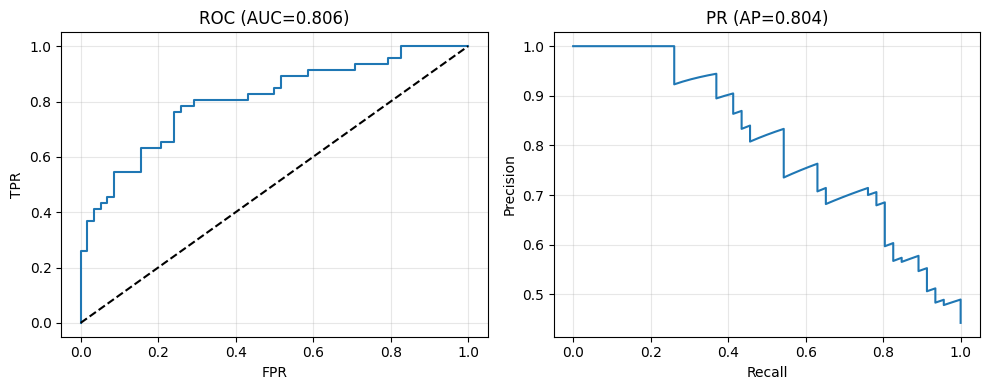

In [10]:
fpr, tpr, _ = roc_curve(y_test, err_test)
prec, rec, _ = precision_recall_curve(y_test, err_test)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'k--')
plt.title(f"ROC (AUC={roc_auc_score(y_test, err_test):.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(alpha=0.3)
plt.subplot(1,2,2); plt.plot(rec, prec)
plt.title(f"PR (AP={average_precision_score(y_test, err_test):.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()


In [11]:
# pipeline'ı da kaydedelim ki üretimde aynısını kullanalım
ae.save("ae_fraud_best.keras")
joblib.dump(preprocess, "preprocess_ae.joblib")
json.dump({"threshold_f1": float(thr_f1),
           "threshold_p90": float(thr_p9)}, open("ae_thresholds.json","w"))

# Yükleme ve tek örnek skoru
pre2 = joblib.load("preprocess_ae.joblib")
ae2  = tf.keras.models.load_model("ae_fraud_best.keras")
thr  = json.load(open("ae_thresholds.json"))["threshold_f1"]  # ya da threshold_p90

def ae_score_and_label_from_dfrow(row_df, model, preproc, thr):
    Xrow = row_df.drop(labels=["Class"], errors="ignore").to_frame().T  # df->1 satır
    Xp   = preproc.transform(Xrow)
    rec  = model.predict(Xp, verbose=0)
    err  = float(np.mean(np.abs(Xp - rec)))
    return err, int(err >= thr)

In [12]:
# Örnek tek satır (test setinden bir satır):
row = X_test.iloc[0].copy()
row["Class"] = y_test[0]   # sadece gösterim için
score, label = ae_score_and_label_from_dfrow(row, ae2, pre2, thr)
print("Score:", score, "| Pred(1=anomali):", label, "| True:", int(row["Class"]))


Score: 0.22307422602421018 | Pred(1=anomali): 0 | True: 0
